In [34]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
import sklearn.metrics as metrics
from statistics import mean
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import residuals_plot
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from scipy import stats
from sklearn.ensemble import RandomForestRegressor


# PA04
## Jeremy Waibel and London Kasper
This project is an exploration of feature selection and different dimensionality reduction techniques (option 1 of program handout). We are using a dataset provided by Trinity Industries and are performing an analysis of the dataset according to the instructions provided:
> Problem:
Shopping cars (maintenance events) is a large logistical problem for rail car owners and managers. One
pain point is not knowing how long a car will be out of service while in a repair facility (shop). Attached is
a list of shopping events from 2018 to 2019 for various shops. These cars are in shop for the same
reason but some cars may require additional attention.
>
>Goal:
Create a regressor to predict how long a car will be in shop (Cycle Time). 
Use cars completed 1/1/2018
to 5/31/2019 as your training set and provide performance metrics (Mean Absolute Error & Root Mean
Square Error) for cars completed 6/1/2019 to 12/31/2019. Compare your performance metrics with a
baseline (Avg Shop Cycle Time).
>
>Hint: CycleTimedays = DateCompleted − ArrivalDate

### Data Dictionary: 
(Dataset: problem_dataset.csv -> ‘|’ delimited file)
- ArrivalDate, DateCompleted – Datetime
- Age – Years since car was built
- ShopRecordID – Shopping event Identifier
- ShopID – Shop location identifier
- CarModelID – Car model identifier
- CommodityID – Commodity Type Identifier
- IsHeavy – Heavy work for repair event identifier

### What is dimensionality reduction?
In machine learning, features are attributes (or columns) of data that can be used to contribute toward a prediction. You would think that more features would help to produce a more accurate prediction. However, there exists a 'curse of dimentionality' that states that too many features can actually harm a model rather than make it more accurate. Having too many features slows training to halt, but also makes it more difficult to visualize your data.
<br></br> So how would we fix this issue? The simplest answer seems to be to delete columns of data that seem insignificant. However, how do you determine what data is insignificant? Other than flat-out incorrect data, all data points offer information to the overall picture. Sometimes there are components to the dataset that are less significant to the question we're asking. <br></br>For example, if we wanted to predict the weather forecast for the next week based on the previous week's data, we wouldn't want to factor in what day of the week had the most rain (Saturday, Monday, etc). The day of the week is a categorical variable that has nothing to do with the weather conditions that were present that particular week. If we did make a prediction using day of the week as a feature, we would likely end up with a prediction mirroring the conditions of the last week. The day of the week is irrelevant to the conditions of the prediction, so we can discard the information for the model.
<br></br> There is a difference between dimensionality reduction and feature selection that should be noted before we continue. Dimensionality reduction takes multiple features and attempts to condense them into a few features while still preserving the dataset's variance.  On the other hand, feature selection is a decision to take data out of the equation, and does not necessarily mean that the variance of the dataset will still be preserved (unless specifically calculated to do so). Bottom line is, don't throw away data unless you're absolutely sure it's okay to do so.

### Our process
We will first focus on exploratory data analysis, as there is much more information that can be gathered from the dataset before modeling.
After an adequite analysis of the data, we will build an initial regression model to gather a baseline prediction. We will then build a second version of the model, this time using a dataset that has the dimensionality reduced and finally compare the results of the varying models.

# EDA

In [2]:
rawData = pd.read_csv('problem_dataset.csv', delimiter='|',index_col=0,parse_dates=[1,7])
print(rawData.head())
print(rawData.info())
print(rawData.isnull().sum())

             ArrivalDate    Age  ShopID  IsHeavy  CarModelID  CommodityID  \
ShopRecordID                                                                
1             2017-06-27   8.49  471553     True      292204       477991   
2             2017-10-10   7.86  471554     True      292205       477992   
3             2017-10-10   4.32  471555    False      292206       477993   
4             2017-10-04  10.10  471556    False      292207       477994   
5             2017-10-18   9.64  471556     True      292207       477995   

             DateCompleted  
ShopRecordID                
1               2018-01-02  
2               2018-02-24  
3               2018-01-24  
4               2018-06-15  
5               2018-02-16  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7264 entries, 1 to 7264
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ArrivalDate    7264 non-null   datetime64[ns

In [10]:
rawData['CycleTime'] = (rawData['DateCompleted'] - rawData['ArrivalDate']).dt.days
print(rawData['CycleTime'])

ShopRecordID
1       189
2       137
3       106
4       254
5       121
       ... 
7260     63
7261     29
7262     52
7263     34
7264     20
Name: CycleTime, Length: 7264, dtype: int64


In [5]:
#convert to categorical variable datatype
rawData['ShopID'] = pd.Categorical(rawData.ShopID)
rawData['CarModelID'] = pd.Categorical(rawData.CarModelID)
rawData['CommodityID'] = pd.Categorical(rawData.CommodityID)

In [6]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7264 entries, 1 to 7264
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ArrivalDate    7264 non-null   datetime64[ns]
 1   Age            7264 non-null   float64       
 2   ShopID         7264 non-null   category      
 3   IsHeavy        7264 non-null   bool          
 4   CarModelID     7264 non-null   category      
 5   CommodityID    7264 non-null   category      
 6   DateCompleted  7264 non-null   datetime64[ns]
dtypes: bool(1), category(3), datetime64[ns](2), float64(1)
memory usage: 275.7 KB


- All records are valid
- Data is in tidy format
- Categorical/Factor: ShopID, IsHeavy, CarModelID, CommodityID
- Numeric: Age, CycleTime
- Dates: ArrivalDate, DateCompleted

#### "Use cars completed 1/1/2018 to 5/31/2019 as your training set"

In [11]:
rawData['DateCompleted'].min()

Timestamp('2018-01-01 00:00:00')

In [12]:
trainingData = rawData[(rawData['DateCompleted'] <= pd.to_datetime("2019-05-31"))].copy()
trainingData.head()

,ArrivalDate,Age,ShopID,IsHeavy,CarModelID,CommodityID,DateCompleted,CycleTime
ShopRecordID,,,,,,,,
1,2017-06-27,8.49,471553,True,292204,477991,2018-01-02,189
2,2017-10-10,7.86,471554,True,292205,477992,2018-02-24,137
3,2017-10-10,4.32,471555,False,292206,477993,2018-01-24,106
4,2017-10-04,10.10,471556,False,292207,477994,2018-06-15,254
5,2017-10-18,9.64,471556,True,292207,477995,2018-02-16,121


# Analysis Plots
Now's a good time to take a step back and look at our data. What is it doing, and are there any patterns we can notice right off of the bat?

In [13]:
mpl.rcParams['figure.figsize'] = (20, 10)
sns.set(rc = {'figure.figsize':(20,10)})

#### Complete Data

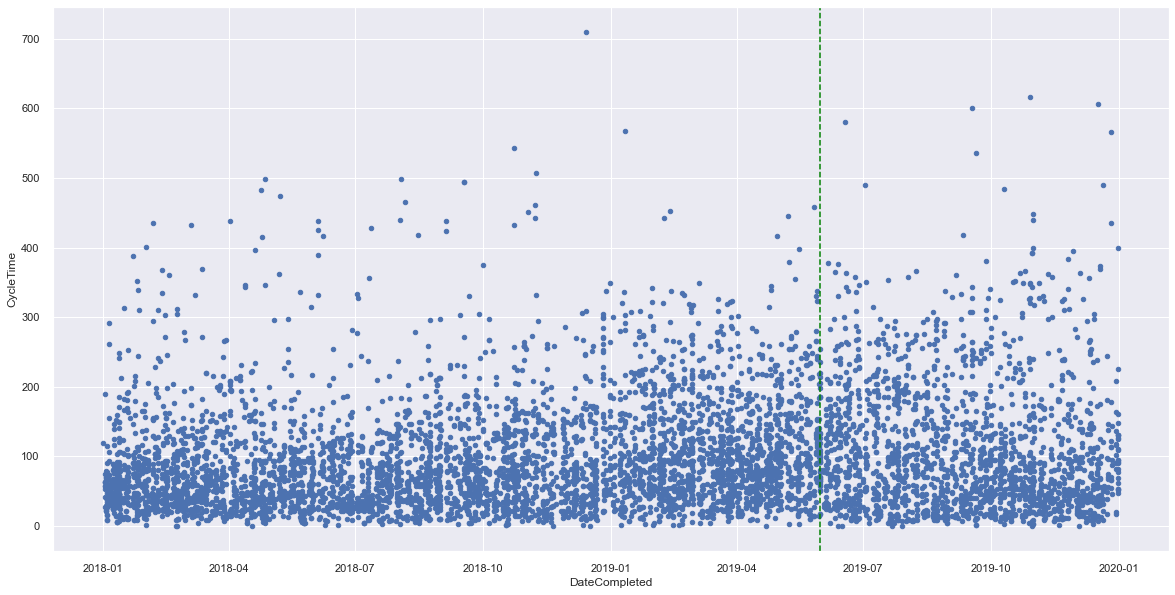

In [14]:
ax = rawData.plot.scatter(x = 'DateCompleted', y = 'CycleTime');
ax.axvline(pd.to_datetime("2019-05-31"), color="green", linestyle="dashed");

- CycleTime seem to be fairly consistent in the training/testing split

#### CycleTime

array([[<AxesSubplot:title={'center':'CycleTime'}>]], dtype=object)

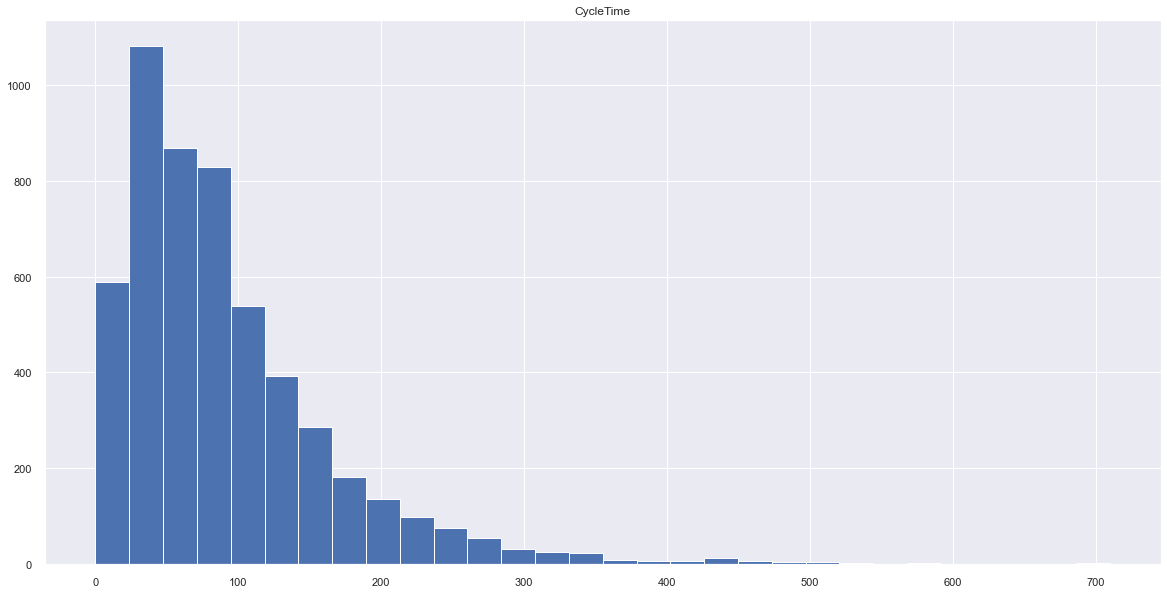

In [15]:
trainingData.hist('CycleTime', bins = 30)

- CycleTime is skewed right, however scaling the target variable is not normally required

#### IsHeavy

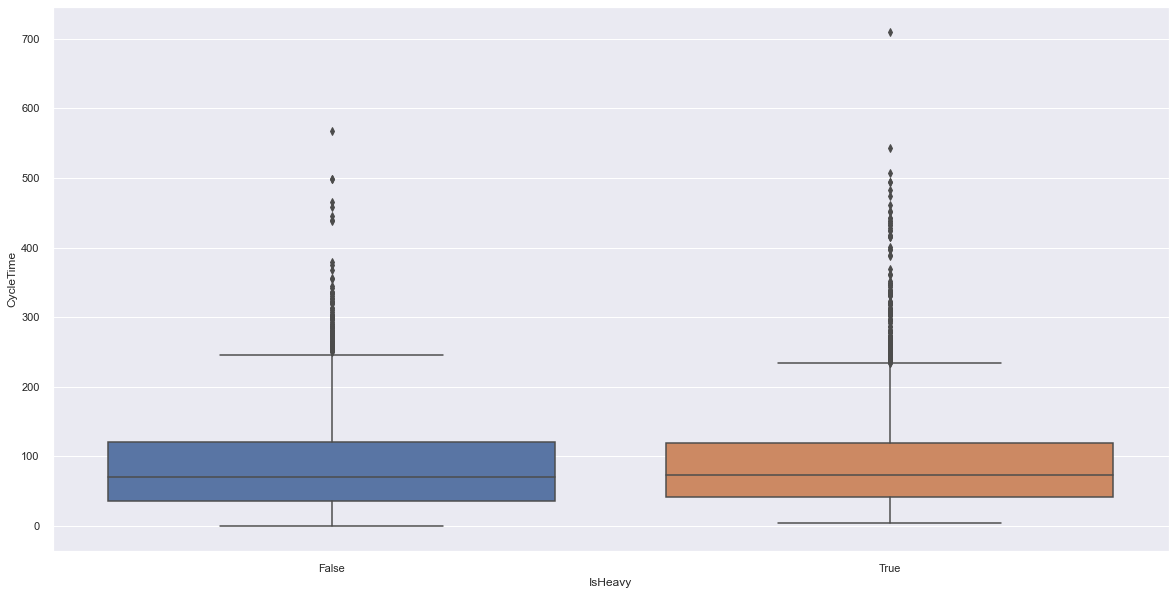

In [16]:
sns.boxplot(x = "IsHeavy", y = "CycleTime", data = trainingData);

In [17]:
trainingData.groupby('IsHeavy')['CycleTime'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
IsHeavy,,,,,,,,
False,1764.0,90.59,74.68,0.0,36.0,71.0,121.0,568.0
True,3488.0,90.91,71.33,4.0,42.0,74.0,119.0,710.0


- Quite a few outiers
- High standard deviation
- While IsHeavy does not seem to affect CycleTime on its own, it may have an interaction with other variables

#### ArrivalDate

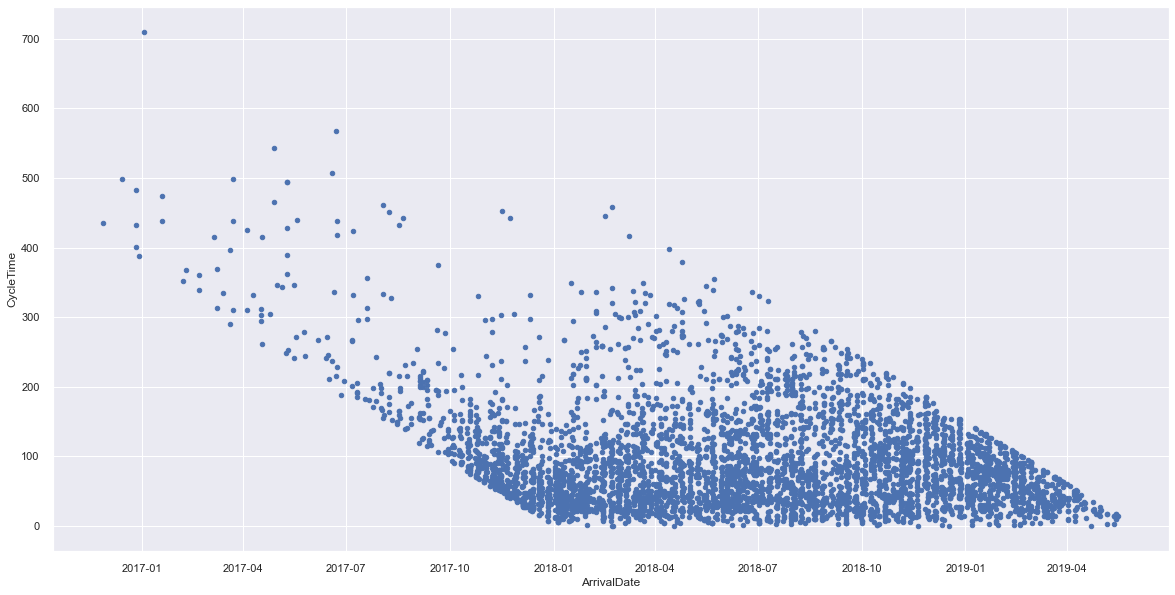

In [18]:
trainingData.plot.scatter('ArrivalDate','CycleTime');

- The shape of the plot indicates that there is a ceiling and floor effect because of the way the data was partitioned
- The CycleTime of the car can only be at most max(DateCompleted) - ArrivalDate
- The CycleTime of the car can only be at least min(DateCompleted) - ArrivalDate
- Instead of just throwing away this data, we can break down ArrivalDate into Months/Days to see if they can provide information

#### ArrivalDate - Month

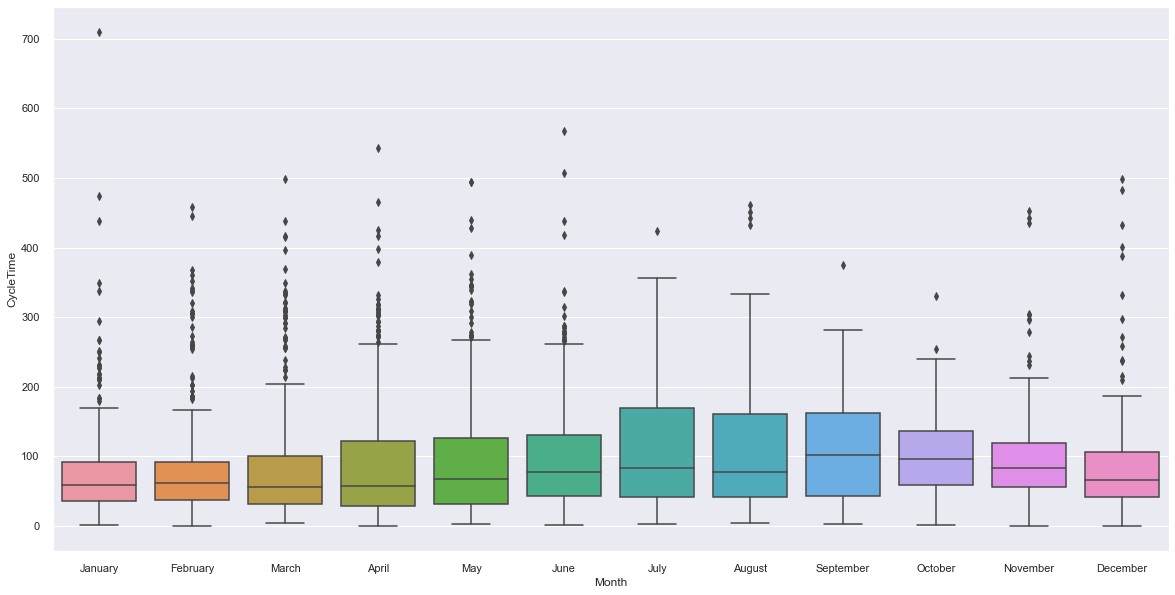

In [19]:
trainingData['Month'] = trainingData['ArrivalDate'].dt.month_name()
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
trainingData['Month'] = pd.Categorical(trainingData['Month'], categories=months, ordered=True)
trainingData.sort_values(by = 'Month')
sns.boxplot(x = "Month", y = "CycleTime", data = trainingData);

- Months may still possess the same ceiling and floor effect that ArrivalDate shows so we decided to break it down further into days of the week

#### ArrivalDate - DayOfWeek

,count,mean,std,min,25%,50%,75%,max
DayOfWeek,,,,,,,,
Monday,1143.0,81.02,67.80,0.0,32.00,63.0,108.00,507.0
Tuesday,1109.0,98.72,75.82,0.0,44.00,77.0,137.00,710.0
Wednesday,1052.0,90.00,68.36,0.0,42.00,75.0,118.00,495.0
Thursday,1165.0,95.54,75.48,0.0,43.00,76.0,125.00,568.0
Friday,630.0,91.86,76.13,0.0,40.00,75.5,118.75,543.0
Saturday,69.0,78.94,66.19,10.0,34.00,54.0,101.00,305.0
Sunday,84.0,65.75,48.72,4.0,29.75,48.5,97.00,262.0


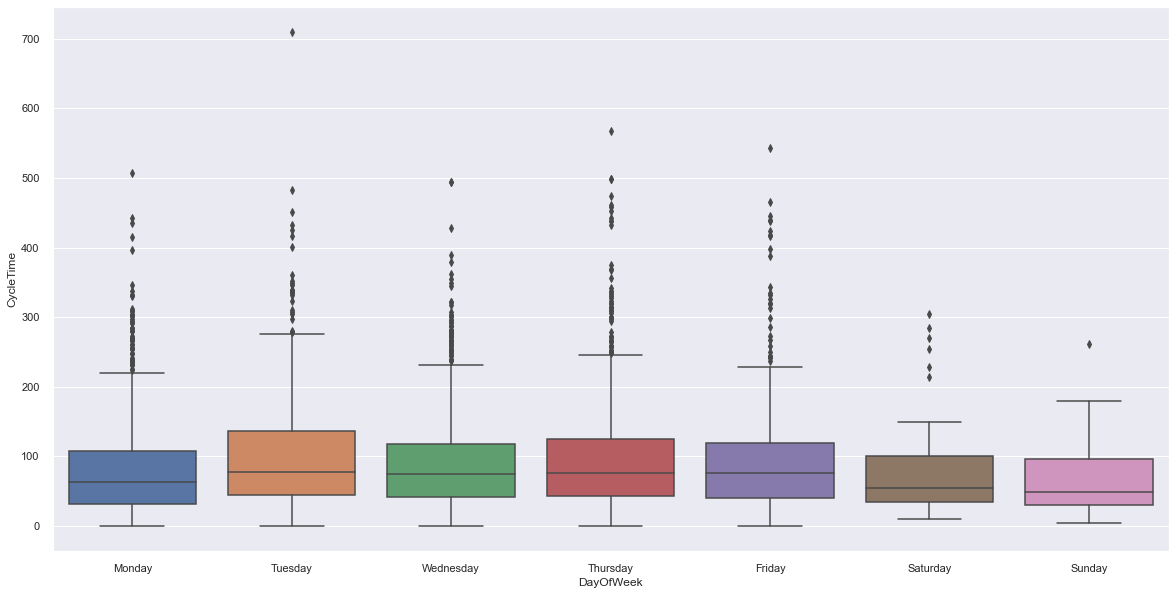

In [20]:
trainingData['DayOfWeek'] = trainingData['ArrivalDate'].dt.day_name()
dayofweek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
trainingData['DayOfWeek'] = pd.Categorical(trainingData['DayOfWeek'], categories=dayofweek, ordered=True)
trainingData.sort_values(by = 'DayOfWeek')
sns.boxplot(x = "DayOfWeek", y = "CycleTime", data = trainingData);
trainingData.groupby('DayOfWeek')['CycleTime'].describe().round(2)

- DayOfWeek seems to have an effect on CycleTime
- There is no ceiling or floor effect using this metric

#### Age

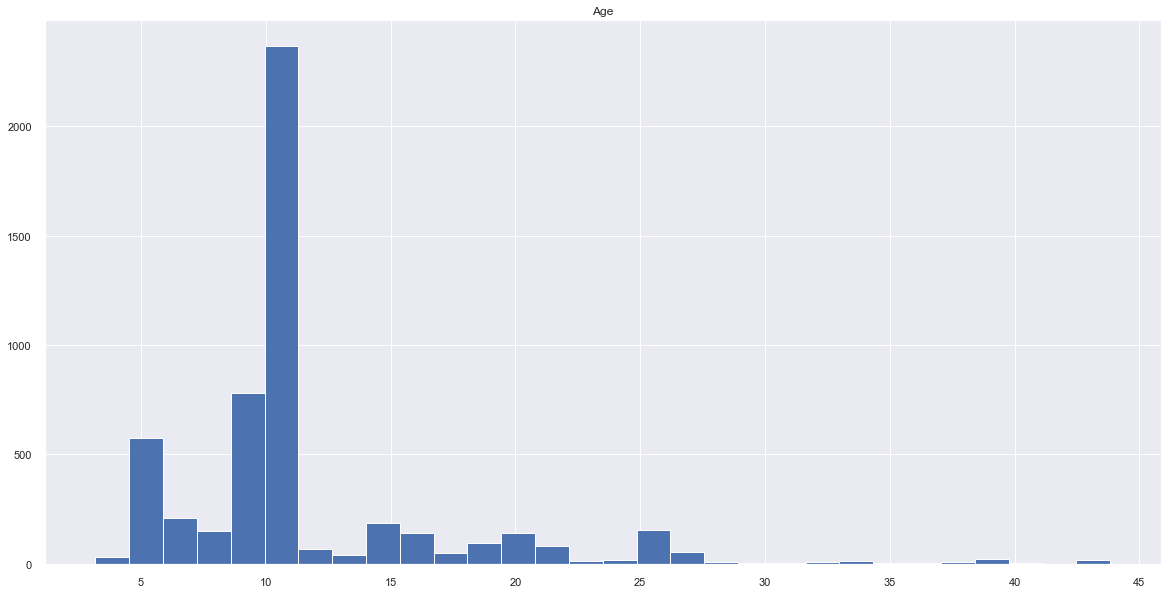

In [21]:
trainingData.hist('Age', bins = 30);

<AxesSubplot:xlabel='Age', ylabel='CycleTime'>

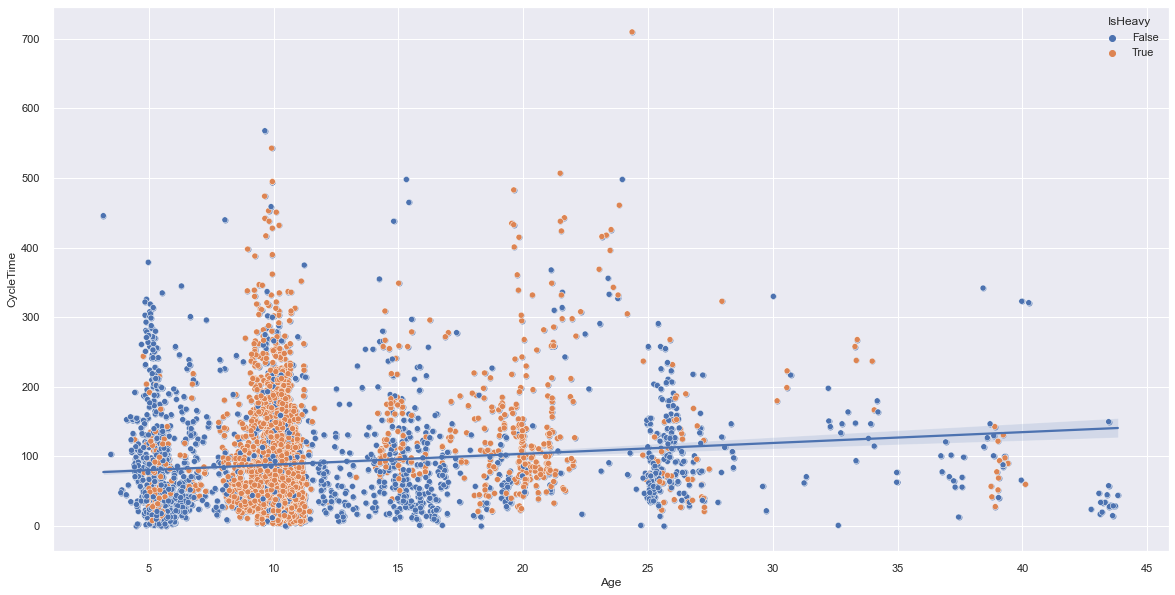

In [22]:
sns.regplot(x = 'Age', y = 'CycleTime', data = trainingData);
sns.scatterplot(x = 'Age', y = 'CycleTime', hue = 'IsHeavy', data = trainingData)

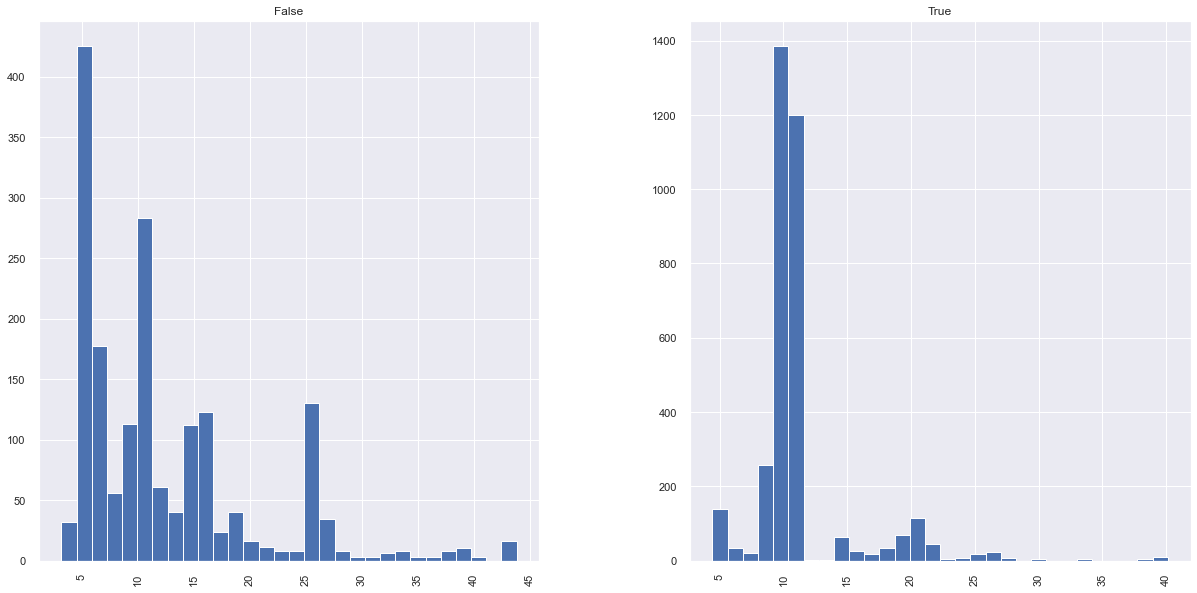

In [23]:
trainingData.hist('Age', by = 'IsHeavy', bins = 30);

,count,mean,std,min,25%,50%,75%,max
IsHeavy,,,,,,,,
False,1764.0,12.35,8.05,3.18,5.79,10.20,15.62,43.82
True,3488.0,11.27,4.15,4.44,9.90,10.34,10.78,40.12


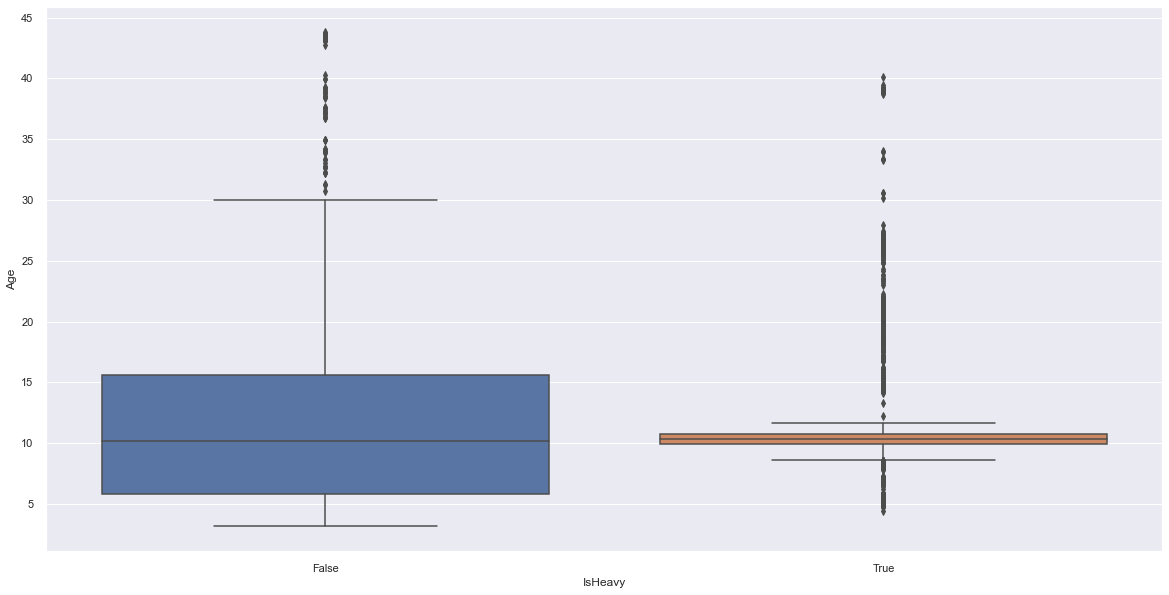

In [24]:
sns.boxplot(x = "IsHeavy", y = "Age", data = trainingData);
trainingData.groupby('IsHeavy')['Age'].describe().round(2)

- Age seems to be a factor in determining CycleTime
- Intresting interaction between IsHeavy and Age
- It seems that cars go into the shop at different ages depending on if they are heavy or not
- Heavy cars seem to go in every 10 years, perhaps for inspections?
- Heavy cars do not typically have as long of a life as non-heavy cars
- A transformation into the Age varible may be explored as the kurtosis is high (Leptokurtic)

#### Categorical Variables (ShopID, CarModelID, CommodityID)

In [25]:
print("Unique Shops:", pd.unique(trainingData['ShopID']).shape[0])
print("Unique Cars:",pd.unique(trainingData['CarModelID']).shape[0])
print("Unique Commodities:",pd.unique(trainingData['CommodityID']).shape[0])

Unique Shops: 30
Unique Cars: 26
Unique Commodities: 294


#### ShopID

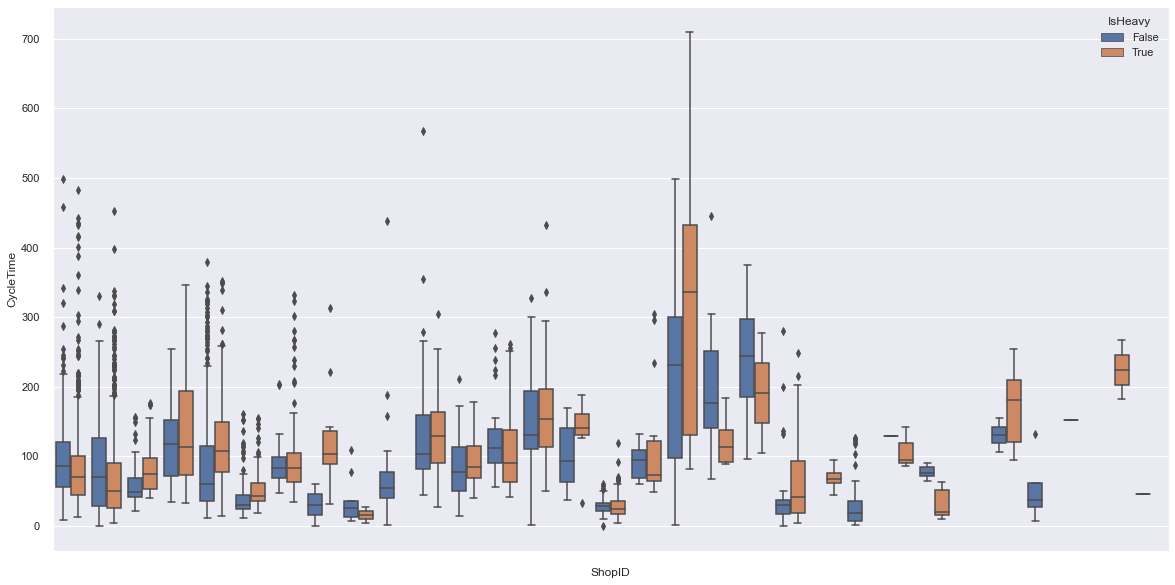

In [31]:
ax = sns.boxplot(x = "ShopID", y = "CycleTime", hue = "IsHeavy", data = trainingData).set(xticklabels=[])

- ShopID seems to be a factor in determining CycleTime
- An interaction between ShopID and IsHeavy could be explored

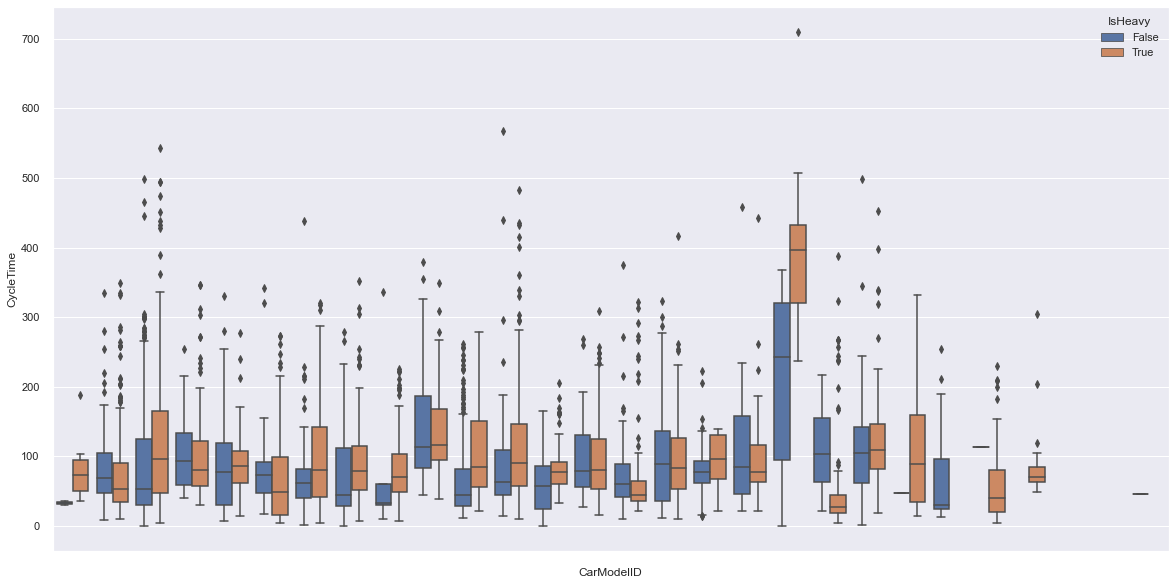

In [30]:
ax = sns.boxplot(x = "CarModelID", y = "CycleTime", hue = "IsHeavy", data = trainingData).set(xticklabels=[])

- CarModelID seems to be a factor in determining CycleTime
- An interaction between CarModelID and IsHeavy could be explored

#### CommodityID

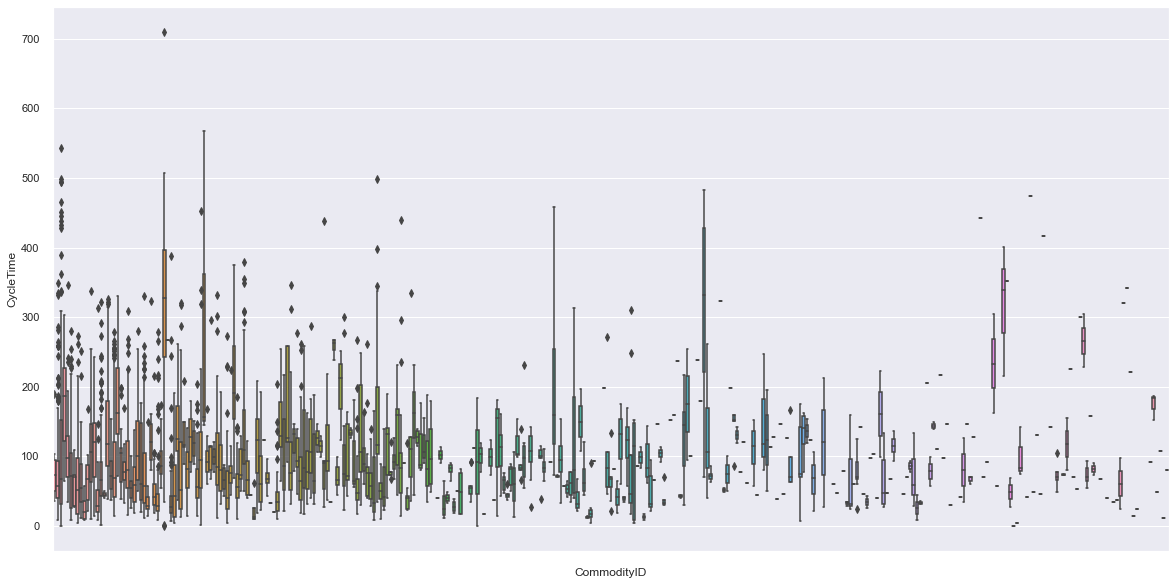

In [32]:
ax = sns.boxplot(x = "CommodityID", y = "CycleTime", data = trainingData).set(xticklabels=[])

- CommodityID seems to be a factor in determining CycleTime

# Initial Model Building

- DateCompleted should not be used to build a model as it is directly correlated with the target variable (CycleTime)
- ShopID, CarModelID, CommodityID, and Age should be considered in the model
- ArrivalDate should not be used to build the model, instead use DayOfWeek

#### Set Up Dummy Variables (One-Hot-Encoding)

In [36]:
rawData['DayOfWeek'] = rawData['ArrivalDate'].dt.day_name()
dummyData = pd.get_dummies(rawData,prefix=['ShopID', 'CarModelID','CommodityID','DayOfWeek'], 
                           columns= ['ShopID', 'CarModelID','CommodityID','DayOfWeek']).copy()

In [37]:
trainDF = dummyData[(dummyData['DateCompleted'] >= pd.to_datetime("2018-01-01")) & (dummyData['DateCompleted'] <= pd.to_datetime("2019-05-31"))].copy()
trainDF['ArrivalDate'] = trainDF['ArrivalDate'].values.astype('float')
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5252 entries, 1 to 7230
Columns: 406 entries, ArrivalDate to DayOfWeek_Wednesday
dtypes: bool(1), datetime64[ns](1), float64(2), int64(1), uint8(401)
memory usage: 2.2 MB


In [38]:
X_train = trainDF
X_train = X_train.drop(['CycleTime'],axis=1)
X_train = X_train.drop(['DateCompleted'],axis=1)
X_train = X_train.drop(['ArrivalDate'],axis=1)
y_train = trainDF['CycleTime'].copy()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
#interaction = PolynomialFeatures(include_bias=False, interaction_only=True)
#X_inter = interaction.fit_transform(X)

#### RandomForestRegressor

In [39]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

# Dimensionality Reduction

The dataset provided only has one numeric datatype (Age), but multiple categorical variables. In the initial model above, the categorical variables selected (DayofWeek, ShopID, CarModelID, CommodityID) were one-hot encoded, resulting in 402 additional columns. This will be the focus of our dimensionality reduction - reducing how many columns there are in the dataset.<br></br>
One thing we didn't anticipate was the difference between dimensionality reduction techniques for categorical variables (like most of our variables are) and numerical variables. There are fewer ways to reduce dimensionality with categorical variables as most dimensionality reduction techniques depend on calculating the variance of the variables.
<br></br>
We wanted to implement the Principal Component Analysis algorithm into our dimensionality reduction, but found that we could not apply PCA to categorical data. We pivoted toward using feature selection methods rather than dimensionality reduction methods.
# More on feature selection
Feature selection is important to do before modeling data. There are a few benefits that can come from this practice, such as a faster training phase. Additionally, there's usually less overfitting because there is less redundant data. This lack of overfitting also contributes to a model with a higher accuracy.

#### k-means clustering
#### MCA

## Model Comparison and Analysis

#### "Provide performance metrics (Mean Absolute Error & Root Mean Square Error) for cars completed 6/1/2019 to 12/31/2019."

In [42]:
testDF = dummyData[(dummyData['DateCompleted'] >= pd.to_datetime("2019-06-01")) & (dummyData['DateCompleted'] <= pd.to_datetime("2019-12-31"))].copy()
X_test = testDF
X_test = X_test.drop(['CycleTime'],axis=1)
X_test = X_test.drop(['DateCompleted'],axis=1)
X_test = X_test.drop(['ArrivalDate'],axis=1)
y_test = testDF['CycleTime'].copy()

#### Initial Random Forest (No Dimensionality Reduction)

In [47]:
print(forestYHat)

[ 70.21       141.78       161.19       ...  39.82933333  88.355
  34.14      ]


MAE:  53.052645195455085
RMSE:  78.70737671346971


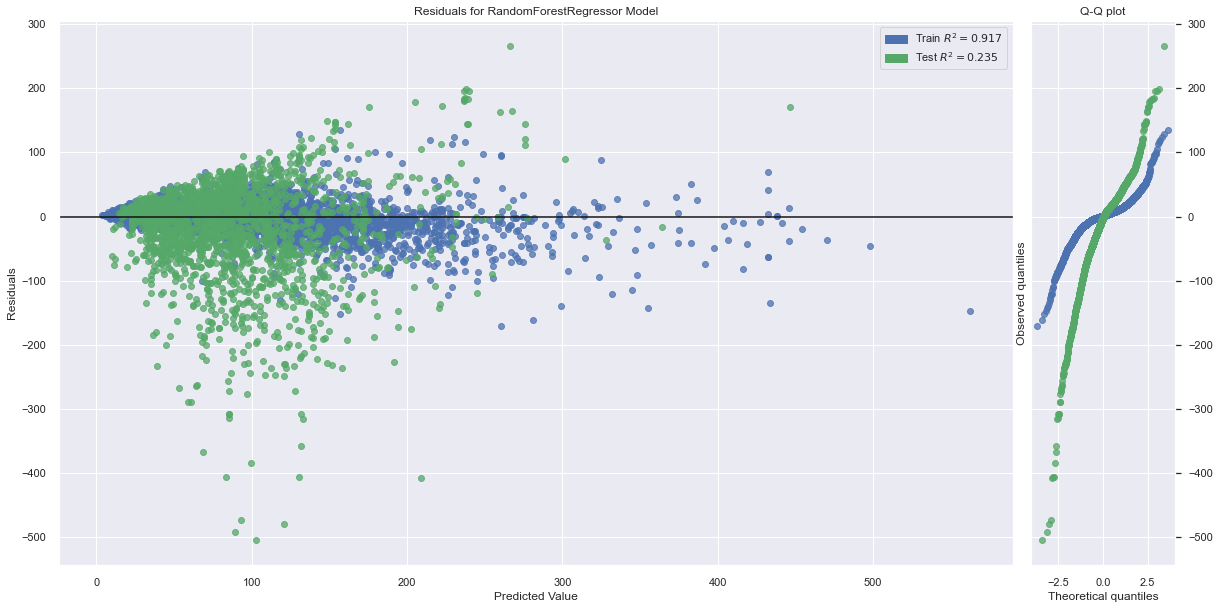

In [45]:
forestYHat = forest_reg.predict(X_test)
forestMAE = metrics.mean_absolute_error(y_test, forestYHat)
forestMSE = metrics.mean_squared_error(y_test, forestYHat)
forestRMSE = np.sqrt(forestMSE) 
print("MAE: ", forestMAE)
print("RMSE: ", forestRMSE)
visualizer = residuals_plot(RandomForestRegressor(), X_train, y_train, X_test, y_test, qqplot = True, hist = False)

# Thoughts and Conclusions

In the end, these models are not able to predict the data effectively. Other models should be explored that take the many outliers into consideration. Regression models such as RANSAC may be able to solve the outlier problem. A non-parametric approach as well as bootstrapping may also be explored. Transformations, such as log, square root, or box-cox, on variables such as CycleTime or Age can help show trends within the data and reduce the effects of outliers. Interactions between variables such as Age and IsHeavy should also be considered, but too many interactions may be subject to the curse of dimensionality. The multimodal shape of the Age variable shoud also be studied.